In [1]:
# Packages
import nltk
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from tqdm import tqdm
warnings.filterwarnings('ignore')

In [2]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

# Import dataset

In [3]:
from sklearn.model_selection import train_test_split, cross_val_score

In [4]:
train = pd.read_csv('train.csv', header=None)
train['Text'] = train[1]+' '+train[2]
train = train.drop(columns=[1,2])

In [5]:
train[0] = train[0].map(lambda x: x-1)
train.rename(columns={0:'Sentiment'},inplace=True)

In [6]:
# Generate a random and balanced small sample for coding 
train_pos = train[train['Sentiment']==1].sample(frac=1)[:25000]
train_neg = train[train['Sentiment']==0].sample(frac=1)[:25000]

train_sp = pd.concat([train_pos, train_neg], axis=0, ignore_index=True)
train_sp = train_sp.sample(frac=1).reset_index(drop=True)

In [7]:
train_sp.tail()

,Sentiment,Text
49995,0,If you wanna play Grand Theft Auto 3- Buy a PS...
49996,1,Gets the job done. I have has the product for ...
49997,0,I highly recommend you do NOT buy this vacuum ...
49998,1,AMAZIN THIS IS ONE OF THE BEST ALBUMS I HAVE E...
49999,1,"Jami Taylor, Agape Book Ministry I thoroughly ..."


In [8]:
train_sp['Sentiment'].value_counts()

1    25000
0    25000
Name: Sentiment, dtype: int64

# Text Processing

In [9]:
# 1. Tokenisation (casual module)
from nltk.tokenize import TweetTokenizer
Tokenizer = TweetTokenizer()
# 2. Remove punctuation
import string
# 3. Remove stopwords
from nltk.corpus import stopwords
# 4. Stemming
from nltk.stem.porter import PorterStemmer

In [10]:
def process_text(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_no_punctuation = [word.lower() for word in tokenized if word not in string.punctuation]
    tokenized_no_stopwords = [word for word in tokenized_no_punctuation if word not in stopwords.words('english')]
    token = [PorterStemmer().stem(word) for word in tokenized_no_stopwords if word != '️']
    token = ' '.join(token)
    return token

In [11]:
def process_text_ez(text):
    text = str(text)
    tokenized = Tokenizer.tokenize(text)
    tokenized_lower = [word.lower() for word in tokenized]
    tokenized_stem = [PorterStemmer().stem(word) for word in tokenized_lower if word != '']
    token = ' '.join(tokenized_stem)
    return token

In [12]:
train_sp['Token'] = train_sp['Text'].apply(process_text)

In [13]:
train_sp['Text'] = train_sp['Text'].apply(process_text_ez)

In [14]:
train_sp.tail()

,Sentiment,Text,Token
49995,0,if you wanna play grand theft auto 3 - buy a p...,wanna play grand theft auto 3 buy ps2 pc total...
49996,1,get the job done . i have ha the product for 5...,get job done product 5 year fail yet power out...
49997,0,i highli recommend you do not buy thi vacuum c...,highli recommend buy vacuum cleaner vacuum cle...
49998,1,amazin thi is one of the best album i have eve...,amazin one best album ever heard.ic cube best ...
49999,1,"jami taylor , agap book ministri i thoroughli ...",jami taylor agap book ministri thoroughli enjo...


In [58]:
(train_sp.Text.apply(len)).mean()

410.1947

In [59]:
(train_sp.Token.apply(len)).mean()

246.02324

In [15]:
# Randomly split indexes 80/20
train_x, valid_x, train_y, valid_y = train_test_split(train_sp['Token'], train_sp['Sentiment'], train_size=0.8, random_state=1, stratify=train_sp.Sentiment)

## Count Vectors (BoW) as features

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# 1-gram
count_vect_1n = CountVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=5000)
count_vect_1n.fit(train_sp['Token'])

# 2-gram
count_vect_2n = CountVectorizer(analyzer='word', ngram_range=(2,2), token_pattern=r'\w{1,}', max_features=5000)
count_vect_2n.fit(train_sp['Token'])

# 3-gram
count_vect_3n = CountVectorizer(analyzer='word', ngram_range=(3,3), token_pattern=r'\w{1,}', max_features=5000)
count_vect_3n.fit(train_sp['Token'])

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(3, 3), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='\\w{1,}', tokenizer=None,
        vocabulary=None)

In [17]:
# Transform the training and validation data using count vectorizer object
xtrain_count_1n =  count_vect_1n.transform(train_x)
xvalid_count_1n =  count_vect_1n.transform(valid_x)

xtrain_count_2n =  count_vect_2n.transform(train_x)
xvalid_count_2n =  count_vect_2n.transform(valid_x)

xtrain_count_3n =  count_vect_3n.transform(train_x)
xvalid_count_3n =  count_vect_3n.transform(valid_x)

## TF-IDF Vectors + N-gram as features

In [18]:
# 1-gram
tfidf_vect_1n = TfidfVectorizer(analyzer='word', ngram_range=(1,1), token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect_1n.fit(train_sp['Token'])

# 2-gram
tfidf_vect_2n = TfidfVectorizer(analyzer='word', ngram_range=(2,2), token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect_2n.fit(train_sp['Token'])

# 3-gram
tfidf_vect_3n = TfidfVectorizer(analyzer='word', ngram_range=(3,3), token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect_3n.fit(train_sp['Token'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=5000, min_df=1,
        ngram_range=(3, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='\\w{1,}', tokenizer=None, use_idf=True,
        vocabulary=None)

In [19]:
xtrain_tfidf_1n =  tfidf_vect_1n.transform(train_x)
xvalid_tfidf_1n =  tfidf_vect_1n.transform(valid_x)

xtrain_tfidf_2n =  tfidf_vect_2n.transform(train_x)
xvalid_tfidf_2n =  tfidf_vect_2n.transform(valid_x)

xtrain_tfidf_3n =  tfidf_vect_3n.transform(train_x)
xvalid_tfidf_3n =  tfidf_vect_3n.transform(valid_x)

## Word2vec as features

In [20]:
from gensim.models import word2vec

In [21]:
sentence = [(i.split()) for i in train_sp.Text]
w2vmodel = word2vec.Word2Vec(sentence, min_count=1, size=300, workers=4)

In [51]:
w2vmodel.most_similar(['book'])

[('novel', 0.7485477924346924),
 ('author', 0.6498041749000549),
 ('text', 0.6280728578567505),
 ('chapter', 0.6041023135185242),
 ('bibl', 0.6026525497436523),
 ('textbook', 0.6006426811218262),
 ('stori', 0.5985639095306396),
 ('seri', 0.5933400392532349),
 ('reader', 0.5683128833770752),
 ('topic', 0.5670907497406006)]

In [23]:
train_w2v_x, valid_w2v_x, train_w2v_y, valid_w2v_y = train_test_split(train_sp['Text'], train_sp['Sentiment'], train_size=0.8, random_state=1, stratify=train_sp.Sentiment)

In [24]:
def get_sent_vec(size, sent, model):
    vec = np.zeros(size).reshape(1,size)
    count = 0
    for word in sent:
        try:
            vec += model[word].reshape(1,size)
            count += 1
        except:
            continue
    if count != 0:
        vec /= count
    return vec

def get_train_vec(train_x, valid_x, model):
    train_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in train_x])
    test_vec = np.concatenate([get_sent_vec(300, sent, model) for sent in valid_x])
    return train_vec, test_vec

In [25]:
# Lower + No punctuation + No stopwords+ Stemming
train_vec, valid_vec = get_train_vec(train_x, valid_x, w2vmodel)
# Lower words + Stemming
train_w2v_vec, valid_w2v_vec = get_train_vec(train_w2v_x, valid_w2v_x, w2vmodel)

# Model Training (Traditional ML)

In [26]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, f1_score, confusion_matrix, roc_curve
from statlearning import plot_confusion_matrix

In [27]:
from sklearn import naive_bayes, svm, linear_model

def train_model(classifier, feature_vector_train, label, feature_vector_valid, is_neural_net=False):
    # fit the training dataset on the classifier
    trm = classifier.fit(feature_vector_train, label)
    
    # predict the labels on validation dataset
    predictions = trm.predict(feature_vector_valid)
    
    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    print('Accuracy:', accuracy_score(predictions, valid_y).round(4))
    print('Precision:', precision_score(predictions, valid_y).round(4))
    print('Recall:', recall_score(predictions, valid_y).round(4))
    print('F1 Score:', f1_score(predictions, valid_y).round(4))
    '''
    confusion = confusion_matrix(predictions, valid_y)
    fig, ax = plt.subplots(figsize=(8,6))
    plot_confusion_matrix(confusion, classes=['negative','positive'], normalize=True)
    plt.show()
    '''
    #print('AUC:', roc_auc_score(predictions, proba_y[:,1]).round(3),'\n')

##  Naive Bayes

In [28]:
print("# Naive Bayes + Count Vectors + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\n# Naive Bayes + Count Vectors + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\n# Naive Bayes + Count Vectors + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_count_3n, train_y, xvalid_count_3n)

# Naive Bayes + Count Vectors + 1-gram
Accuracy: 0.8399
Precision: 0.8526
Recall: 0.8315
F1 Score: 0.8419

# Naive Bayes + Count Vectors + 2-gram
Accuracy: 0.7947
Precision: 0.8318
Recall: 0.7743
F1 Score: 0.802

# Naive Bayes + Count Vectors + 3-gram
Accuracy: 0.6464
Precision: 0.8824
Recall: 0.5995
F1 Score: 0.7139


In [29]:
print("# Naive Bayes + TF-IDF + 1-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\n# Naive Bayes + TF-IDF + 2-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\n# Naive Bayes + TF-IDF + 3-gram")
train_model(naive_bayes.BernoulliNB(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

# Naive Bayes + TF-IDF + 1-gram
Accuracy: 0.8399
Precision: 0.8526
Recall: 0.8315
F1 Score: 0.8419

# Naive Bayes + TF-IDF + 2-gram
Accuracy: 0.7947
Precision: 0.8318
Recall: 0.7743
F1 Score: 0.802

# Naive Bayes + TF-IDF + 3-gram
Accuracy: 0.6464
Precision: 0.8824
Recall: 0.5995
F1 Score: 0.7139


In [30]:
print("# Naive Bayes + 1234 + Word2vec")
train_model(naive_bayes.BernoulliNB(), train_vec, train_y, valid_vec)

print("\n# Naive Bayes + 14 + Word2vec")
train_model(naive_bayes.BernoulliNB(), train_w2v_vec, train_y, valid_w2v_vec)

# Naive Bayes + 1234 + Word2vec
Accuracy: 0.5576
Precision: 0.5542
Recall: 0.558
F1 Score: 0.5561

# Naive Bayes + 14 + Word2vec
Accuracy: 0.582
Precision: 0.538
Recall: 0.5899
F1 Score: 0.5628


## SVM 

In [31]:
print("SVM + Count Vectors + 1-gram")
train_model(svm.SVC(verbose=True), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nSVM + Count Vectors + 2-gram")
train_model(svm.SVC(verbose=True), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nSVM + Count Vectors + 3-gram")
train_model(svm.SVC(verbose=True), xtrain_count_3n, train_y, xvalid_count_3n)

SVM + Count Vectors + 1-gram
[LibSVM]Accuracy: 0.8308
Precision: 0.8156
Recall: 0.8412
F1 Score: 0.8282

SVM + Count Vectors + 2-gram
[LibSVM]Accuracy: 0.5604
Precision: 0.9848
Recall: 0.5327
F1 Score: 0.6914

SVM + Count Vectors + 3-gram
[LibSVM]Accuracy: 0.5012
Precision: 0.9996
Recall: 0.5006
F1 Score: 0.6671


In [32]:
print("SVM + TF-IDF + 1-gram")
train_model(svm.SVC(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nSVM + TF-IDF + 2-gram")
train_model(svm.SVC(), xtrain_tfidf_2n, train_y, xvalid_tfidf_2n)

print("\nSVM + TF-IDF + 3-gram")
train_model(svm.SVC(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

SVM + TF-IDF + 1-gram
Accuracy: 0.7248
Precision: 0.4868
Recall: 0.929
F1 Score: 0.6388

SVM + TF-IDF + 2-gram
Accuracy: 0.5495
Precision: 0.9972
Recall: 0.5261
F1 Score: 0.6888

SVM + TF-IDF + 3-gram
Accuracy: 0.5595
Precision: 0.1502
Recall: 0.828
F1 Score: 0.2543


In [33]:
print("SVM + 1234 + Word2vec")
train_model(svm.SVC(), train_vec, train_y, valid_vec)

print("\nSVM + 14 + Word2vec")
train_model(svm.SVC(), train_w2v_vec, train_y, valid_w2v_vec)

SVM + 1234 + Word2vec
Accuracy: 0.5777
Precision: 0.5724
Recall: 0.5785
F1 Score: 0.5754

SVM + 14 + Word2vec
Accuracy: 0.6015
Precision: 0.6022
Recall: 0.6014
F1 Score: 0.6018


## Logistic Regression 

In [34]:
print("Logistic Regression + Count Vectors + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_1n, train_y, xvalid_count_1n)

print("\nLogistic Regression + Count Vectors + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_2n, train_y, xvalid_count_2n)

print("\nLogistic Regression + Count Vectors + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_count_3n, train_y, xvalid_count_3n)

Logistic Regression + Count Vectors + 1-gram
Accuracy: 0.8629
Precision: 0.8694
Recall: 0.8582
F1 Score: 0.8638

Logistic Regression + Count Vectors + 2-gram
Accuracy: 0.7856
Precision: 0.7714
Recall: 0.7939
F1 Score: 0.7825

Logistic Regression + Count Vectors + 3-gram
Accuracy: 0.6422
Precision: 0.8702
Recall: 0.5977
F1 Score: 0.7086


In [35]:
print("Logistic Regression + TF-IDF + 1-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_1n, train_y, xvalid_tfidf_1n)

print("\nLogistic Regression + TF-IDF + 2-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_2n, train_y, xvalid_tfidf_3n)

print("\nLogistic Regression + TF-IDF + 3-gram")
train_model(linear_model.LogisticRegression(), xtrain_tfidf_3n, train_y, xvalid_tfidf_3n)

Logistic Regression + TF-IDF + 1-gram
Accuracy: 0.8767
Precision: 0.8776
Recall: 0.876
F1 Score: 0.8768

Logistic Regression + TF-IDF + 2-gram
Accuracy: 0.5133
Precision: 0.2694
Recall: 0.526
F1 Score: 0.3563

Logistic Regression + TF-IDF + 3-gram
Accuracy: 0.6453
Precision: 0.8722
Recall: 0.5999
F1 Score: 0.7109


In [36]:
print("Logistic Regression + 1234 + Word2vec")
train_model(linear_model.LogisticRegression(), train_vec, train_y, valid_vec)

print("\nLogistic Regression + 14 + Word2vec")
train_model(linear_model.LogisticRegression(), train_w2v_vec, train_y, valid_w2v_vec)

Logistic Regression + 1234 + Word2vec
Accuracy: 0.6164
Precision: 0.6182
Recall: 0.616
F1 Score: 0.6171

Logistic Regression + 14 + Word2vec
Accuracy: 0.6488
Precision: 0.6494
Recall: 0.6486
F1 Score: 0.649


# Model Training (DNN)

In [37]:
from keras.preprocessing import text, sequence
from keras import layers, models, optimizers

Using TensorFlow backend.


## CNN

In [64]:
MAX_SEQUENCE_LENGTH = 128 
EMBEDDING_DIM = 100
VALIDATION_SPLIT = 0.16
TEST_SPLIT = 0.2

In [65]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np

# One-hot
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sp['Token'])
sequences = tokenizer.texts_to_sequences(train_sp['Token'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(train_sp['Sentiment']))
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 67090 unique tokens.
Shape of data tensor: (50000, 128)
Shape of label tensor: (50000, 2)


In [66]:
p1 = int(len(data)*(1-VALIDATION_SPLIT-TEST_SPLIT))
p2 = int(len(data)*(1-TEST_SPLIT))
x_train = data[:p1]
y_train = labels[:p1]
x_val = data[p1:p2]
y_val = labels[p1:p2]
x_test = data[p2:]
y_test = labels[p2:]
print('train rows: '+str(len(x_train)))
print('valid rows: '+str(len(x_val)))
print('test rows: '+str(len(x_test)))

train rows: 31999
valid rows: 8001
test rows: 10000


In [71]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn = Sequential()
cnn.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
cnn.add(Dropout(0.2))
cnn.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn.add(MaxPooling1D(3))
cnn.add(Flatten())
cnn.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn.add(Dense(labels.shape[1], activation='softmax'))
cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 128, 100)          6709100   
_________________________________________________________________
dropout_13 (Dropout)         (None, 128, 100)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 126, 250)          75250     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10500)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 100)               1050100   
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 202       
Total para

Train on 31999 samples, validate on 8001 samples
Epoch 1/3
31999/31999 [==============================] - 87s 3ms/step - loss: 0.3840 - acc: 0.8235 - val_loss: 0.3019 - val_acc: 0.8735
Epoch 2/3
31999/31999 [==============================] - 70s 2ms/step - loss: 0.2499 - acc: 0.8997 - val_loss: 0.3111 - val_acc: 0.8728
Epoch 3/3
31999/31999 [==============================] - 82s 3ms/step - loss: 0.1922 - acc: 0.9244 - val_loss: 0.3178 - val_acc: 0.8709


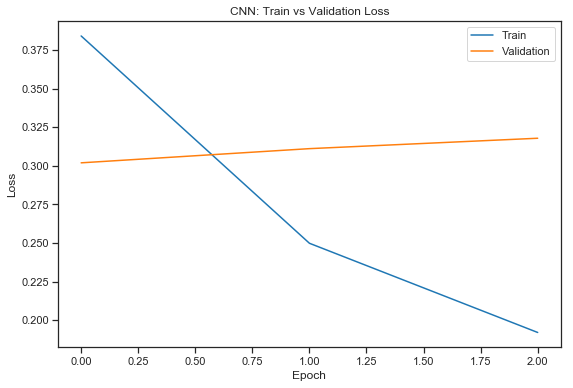

10000/10000 [==============================] - 7s 664us/step
[Test] Loss: 0.3195686294674873
[Test] Accuracy: 0.8716


In [72]:
# CNN + One-hot
cnn.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = cnn.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=64)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = cnn.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [43]:
# Word2vec
from keras.utils import plot_model
from keras.layers import Embedding

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in w2vmodel:
        embedding_matrix[i] = np.asarray(w2vmodel[str(word)],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False)


In [52]:
# CNN + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

cnn_w2v = Sequential()
cnn_w2v.add(embedding_layer)
cnn_w2v.add(Dropout(0.2))
cnn_w2v.add(Conv1D(250, 3, padding='valid', activation='relu', strides=1))
cnn_w2v.add(MaxPooling1D(3))
cnn_w2v.add(Flatten())
cnn_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
cnn_w2v.add(Dense(labels.shape[1], activation='softmax'))
cnn_w2v.summary()

cnn_w2v.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = cnn_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = cnn_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_8 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 126, 250)          225250    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 10500)             0         
_________________________________________________________________
dense_20 (Dense)             (None, 300)               3150300   
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 602       
Total para

[5.112500967597962, 0.6796]

## LSTM 

In [46]:
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm = Sequential()
lstm.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
lstm.add(Dropout(0.2))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm.add(Dense(labels.shape[1], activation='softmax'))
lstm.summary()

lstm.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = lstm.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = lstm.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 129       
_________________________________________________________________
dense_9 (Dense)              (None, 300)               600       
_________________________________________________________________
dense_10 (Dense)             (None, 2)                 602       
Total params: 20,348,279
Trainable params: 20,348,279
Non-trainable params: 0
________________________________________________________________

[0.33459731278419497, 0.8614]

In [60]:
# Word2vec
from keras.utils import plot_model
from keras.layers import Embedding

embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items(): 
    if str(word) in w2vmodel:
        embedding_matrix[i] = np.asarray(w2vmodel[str(word)],dtype='float32')
        
embedding_layer = Embedding(len(word_index) + 1, EMBEDDING_DIM, weights=[embedding_matrix], input_length=MAX_SEQUENCE_LENGTH, trainable=False)


In [50]:
# LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, MaxPooling1D, Embedding
from keras.models import Sequential

lstm_w2v = Sequential()
lstm_w2v.add(embedding_layer)
lstm_w2v.add(Dropout(0.2))
lstm_w2v.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm_w2v.add(Dense(1, activation='sigmoid'))
lstm_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
lstm_w2v.add(Dense(labels.shape[1], activation='softmax'))
lstm_w2v.summary()

lstm_w2v.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = lstm_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = lstm_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_7 (Dropout)          (None, 128, 300)          0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 128)               219648    
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_18 (Dense)             (None, 300)               600       
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 602       
Total params: 20,348,279
Trainable params: 220,979
Non-trainable params: 20,127,300
__________________________________________________________

[0.2884707634925842, 0.8802]

## Hybrid Model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 128, 300)          20127300  
_________________________________________________________________
dropout_11 (Dropout)         (None, 128, 300)          0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 126, 250)          225250    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 42, 250)           0         
_________________________________________________________________
lstm_8 (LSTM)                (None, 128)               194048    
_________________________________________________________________
dense_28 (Dense)             (None, 2)                 258       
_________________________________________________________________
dense_29 (Dense)             (None, 300)               900       
__________

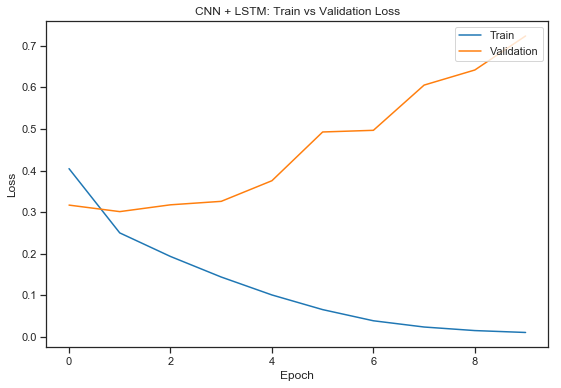

10000/10000 [==============================] - 11s 1ms/step
[Test] Loss: 0.7488823291540145
[Test] Accuracy: 0.8488


In [63]:
# CNN + LSTM
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid = Sequential()
hybrid.add(Embedding(len(word_index) + 1, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
hybrid.add(Dropout(0.2))
hybrid.add(Conv1D(250, 3, activation='relu'))
hybrid.add(MaxPooling1D(pool_size=3))
hybrid.add(LSTM(128))
hybrid.add(Dense(2, activation='sigmoid'))
hybrid.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid.add(Dense(labels.shape[1], activation='softmax'))
hybrid.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid.summary()

hybrid.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = hybrid.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=10, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + LSTM: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = hybrid.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

In [ ]:
# CNN + LSTM + Word2vec
from keras.layers import Dense, Input, Flatten, Dropout
from keras.layers import LSTM, Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Sequential

hybrid_w2v = Sequential()
hybrid_w2v.add(embedding_layer)
hybrid_w2v.add(Dropout(0.2))
hybrid_w2v.add(Conv1D(250, 3, activation='relu'))
hybrid_w2v.add(MaxPooling1D(pool_size=3))
hybrid_w2v.add(LSTM(128))
hybrid_w2v.add(Dense(2, activation='sigmoid'))
hybrid_w2v.add(Dense(EMBEDDING_DIM, activation='relu'))
hybrid_w2v.add(Dense(labels.shape[1], activation='softmax'))
hybrid_w2v.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
hybrid_w2v.summary()

hybrid_w2v.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])
history = hybrid_w2v.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=5, batch_size=128)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('CNN + LSTM + Word2vec: Train vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

result = hybrid_w2v.evaluate(x_test, y_test)
print('[Test] Loss:', result[0])
print('[Test] Accuracy:', result[1])

# Optimisation (CV: Parameters & Features Selection)

# Reflection